# MARKER-CONTROLLED WATERSHED FOR LUNG SEGMENTATION

SPECIAL TOPIC BIOMEDICAL ENGINEERING

Name: Valencia

Student ID: 19/446479/TK/49584

For code explanation, please refer to the final exam report (inside the zip file) or this link: https://docs.google.com/document/d/18JHI4u5qtMEtXEwFvlD8MhTZmxd2k8e87YEPnRCms6I/edit?usp=sharing, thank you

### 1) Pydicom Library for Image Scan Use

In [2]:
!pip install pydicom

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


### 2) Import Library

In [3]:
%matplotlib inline

#Import Library
import numpy as np
import pandas as pd
import pydicom
import os
import scipy.ndimage as ndimage
from skimage import measure, morphology, segmentation
import matplotlib.pyplot as plt
import time

### 3) Load Patient's Data

In [4]:
folder_input = '/kaggle/input/osic-pulmonary-fibrosis-progression/train/'

pasien = os.listdir(folder_input)
pasien.sort()

### 4) Load Scans

In [5]:
def load_scan(path):
    
    slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.InstanceNumber))
    
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

In [6]:
def get_pixels_hu(scans):
    
    image = np.stack([s.pixel_array for s in scans])
    image = image.astype(np.int16)
    
    image[image == -2000] = 0
   
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

In [10]:
patient_scans = load_scan(folder_input + pasien[24])
patient_images = get_pixels_hu(patient_scans)

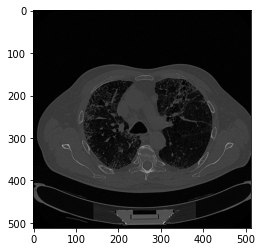

In [12]:
plt.imshow(patient_images[10], cmap='gray')
plt.show()

### 5) Markers

In [13]:
def generate_markers(image):
    
    #Internal Marker
    internal_marker = image < -400
    internal_marker = segmentation.clear_border(internal_marker)
    internal_marker_labels = measure.label(internal_marker)
    
    areas = [r.area for r in measure.regionprops(internal_marker_labels)]
    areas.sort()
    
    if len(areas) > 2:
        for region in measure.regionprops(internal_marker_labels):
            if region.area < areas[-2]:
                for coordinates in region.coords:                
                       internal_marker_labels[coordinates[0], coordinates[1]] = 0
    
    internal_marker = internal_marker_labels > 0
    
    # External Marker
    external_one = ndimage.binary_dilation(internal_marker, iterations=10)
    external_two = ndimage.binary_dilation(internal_marker, iterations=55)
    external_marker = external_one ^ external_two
    
    # Watershed Marker
    watershed_marker = np.zeros((512, 512), dtype=np.int)
    watershed_marker += internal_marker * 255
    watershed_marker += external_marker * 128
    
    return internal_marker, external_marker, watershed_marker

### 6) Markers Example

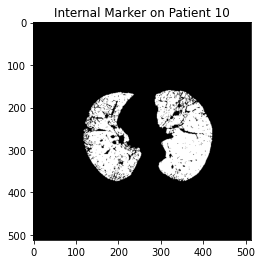

In [14]:
internal_onpatient, external_onpatient, watershed_onpatient = generate_markers(patient_images[10])

plt.imshow(internal_onpatient, cmap='gray')
plt.title("Internal Marker on Patient 10")
plt.show()

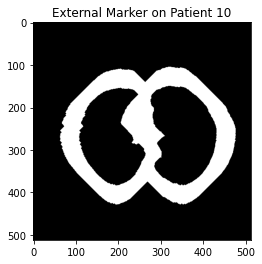

In [15]:
plt.imshow(external_onpatient, cmap='gray')
plt.title("External Marker on Patient 10")
plt.show()

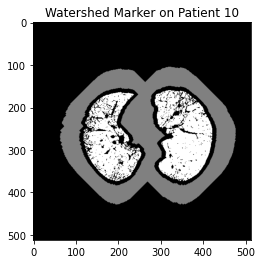

In [16]:
plt.imshow(watershed_onpatient, cmap='gray')
plt.title("Watershed Marker on Patient 10")
plt.show()

### 7) Sobel Gradient (Edge)

In [17]:
def seperate_lungs(image, iterations = 1):
    
    internal_marker, external_marker, watershed_marker = generate_markers(image)
    
    # Sobel Gradient
    sobel_filtered_dx = ndimage.sobel(image, 1)
    sobel_filtered_dy = ndimage.sobel(image, 0)
    sobel_gradient = np.hypot(sobel_filtered_dx, sobel_filtered_dy)
    sobel_gradient *= 255.0 / np.max(sobel_gradient)

    watershed = morphology.watershed(sobel_gradient, watershed_marker)
    
    outline = ndimage.morphological_gradient(watershed, size=(3,3))
    outline = outline.astype(bool)
    
    # Blackhat Structure Filter
    blackhat_struct = [[0, 0, 1, 1, 1, 0, 0],
                       [0, 1, 1, 1, 1, 1, 0],
                       [1, 1, 1, 1, 1, 1, 1],
                       [1, 1, 1, 1, 1, 1, 1],
                       [1, 1, 1, 1, 1, 1, 1],
                       [0, 1, 1, 1, 1, 1, 0],
                       [0, 0, 1, 1, 1, 0, 0]]
    
    blackhat_struct = ndimage.iterate_structure(blackhat_struct, iterations)
    
    outline += ndimage.black_tophat(outline, structure=blackhat_struct)

    lung_filter = np.bitwise_or(internal_marker, outline)
    lung_filter = ndimage.morphology.binary_closing(lung_filter, structure=np.ones((5,5)), iterations=3)

    segmented_lung = np.where(lung_filter == 1, image, -2000*np.ones((512, 512)))
    
    
    return segmented_lung, lung_filter, outline, watershed, sobel_gradient

### 8) Result for Patient 10

In [18]:
for itrs in range(1, 9):
    segmented_test, lungfilter_test, outline_test, watershed_test, sobel_gradient_test = seperate_lungs(patient_images[10], itrs)

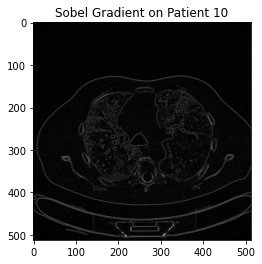

In [19]:
#Sobel-Gradient
plt.imshow(sobel_gradient_test, cmap='gray')
plt.title("Sobel Gradient on Patient 10")
plt.show()

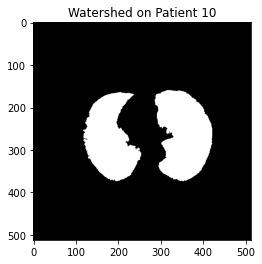

In [20]:
#Watershed
plt.imshow(watershed_test, cmap='gray')
plt.title("Watershed on Patient 10")
plt.show()

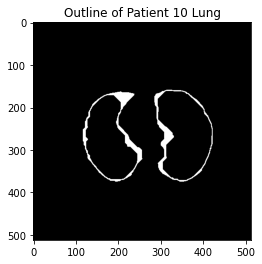

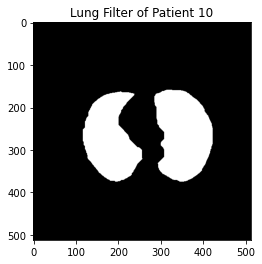

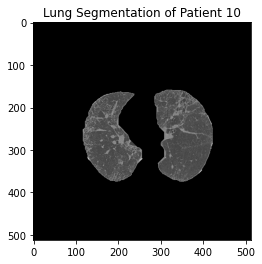

In [21]:
#Outline
plt.imshow(outline_test, cmap='gray')
plt.title("Outline of Patient 10 Lung")
plt.show()

#Filter
plt.imshow(lungfilter_test, cmap='gray')
plt.title("Lung Filter of Patient 10")
plt.show()

#Segmentation
plt.imshow(segmented_test, cmap='gray')
plt.title("Lung Segmentation of Patient 10")
plt.show()

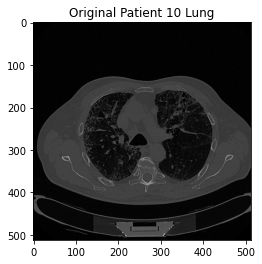

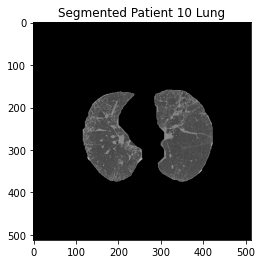

In [24]:
#Result for Patient 10
plt.imshow(patient_images[10], cmap='gray')
plt.title("Original Patient 10 Lung")
plt.show()

plt.imshow(segmented_test, cmap='gray')
plt.title("Segmented Patient 10 Lung")
plt.show()